## 🔍 Market Regime Detection
The various decisions and actions for profit-seeking in financial markets is driven largely by how those markets behave. When asset prices have steadily been in an upward trend for the past several months, for example, many would stay invested or even use leverage to capture more gains. On the other hand, when priecs rise along with higher interest rate, as in a couple years ago, perhaps it’s safer to opt for commodity-related investments.\
These distinct patterns of market behavior are known as market regimes, and they often shift because of changing government policy or broader macroeconomic conditions. Consequently, the effectiveness of different investments can also change, with impacts on returns, volatility, and how prices move over time. \
For this reason, it is vital to detect market regime shifts so that traders and investors can stay informed to make the best choice of quantitative strategy and portfolio allocation to better align with current environment and maximize returns.\
Below are some popular techniques and their applications.

In [340]:
# Import financial data fetching function from first project
import sys
import os

# Use current working directory as base (Jupyter-safe)
project1_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'Financial-Data-API-Research-Week1'))
sys.path.append(project1_path)

# Import the function
from main import fetch_daily_data

## 📏 Rule-based Method
Rule-based methods rely on explicit thresholds derived from indicators like volatility, momentum, or moving averages. These methods are simple, transparent, and effective for making real-time risk management decisions, such as adjusting position sizes or stop-loss distances.\
One classic practice is that traders maintain an exposure/position and stop-loss tightness that inversely correlates with volatility.

In [341]:
# Import and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [342]:
# Load historical AAPL data
data = fetch_daily_data("AAPL", "2023-01-01", "2025-06-27").sort_index(ascending = True)

# Calculate log return
data['logReturn'] = np.log(data['adjClose']).diff()

# Rolling 20-day volatility as risk regime proxy
data['volatility'] = data['logReturn'].rolling(window=20).std()

# Define regime: High if above median, else low
data['riskRegime'] = np.where(data['volatility'] > data['volatility'].median(), 'High', 'Low')

# Adjust position size as a % of normal size: lower when uncertain, higher when favorable
data['posSize (%)'] = np.where(data['riskRegime'] == 'High', 0.5, 1.0)

# Adjust stop-loss as a % of price: looser when uncertain, tighter when favorable
data['stopLoss (%)'] = np.where(data['riskRegime'] == 'High', 2 * data['volatility'], 1 * data['volatility'])

# Sort data in descending order of date
data = data.sort_index(ascending = False)

data.head()

,open,high,low,close,volume,adjClose,logReturn,volatility,riskRegime,posSize (%),stopLoss (%)
2025-06-27,201.890,203.22,200.0000,201.08,73188571,201.08,0.000398,0.010631,Low,1.0,0.010631
2025-06-26,201.430,202.64,199.4600,201.00,50799121,201.00,-0.002782,0.010647,Low,1.0,0.010647
2025-06-25,201.450,203.67,200.6201,201.56,39525730,201.56,0.006271,0.010626,Low,1.0,0.010626
2025-06-24,202.590,203.44,200.2000,200.30,54064033,200.30,-0.005973,0.011921,Low,1.0,0.011921
2025-06-23,201.625,202.30,198.9600,201.50,55814272,201.50,0.002484,0.013841,Low,1.0,0.013841


A more well-studied, sophisticated rule-based algorithm is the Lunde and Timmermann (LT) approach that detects bull and bear markets from historical price data.

In [359]:
# Lunde and Timmermann (2004) regime detection algorithm
def detect_lt_regime(ticker: str, start_date: str, end_date: str | None, price_col='adjClose', lambda1=0.2, lambda2=0.15):
    """
    Implements Lunde and Timmermann (2004) regime detection given a ticker and a price-fetching function.

    Parameters:
    - ticker: str, e.g. "AAPL"
    - start_date: str, start date of price data
    - end_date: str | None, end date of price data
    - price_col: column name to use for price (default: 'adjClose')
    - lambda1: threshold for upward movement from trough (default: 0.2)
    - lambda2: threshold for downward movement from peak (default: 0.2)

    Returns:
    - DataFrame with columns: original + regime, peak, trough
    """

    # Fetech data
    df = fetch_daily_data(ticker, start_date, end_date).sort_index(ascending=True)
    prices = df[price_col]
    n = len(prices)

    # Initializations for regime detection
    max_count, min_count = 0, 0
    p_max, p_min = prices.iloc[0], prices.iloc[0]
    last_extreme_type, last_extreme_value = None, None

    for t in range(1, n):
        pt = prices.iloc[t]
        if pt > p_max:
            p_max = pt
            max_count += 1
        elif pt < p_min:
            p_min = pt
            min_count += 1

        if max_count >= 3:
            last_extreme_type = "peak"
            break
        elif min_count >= 3:
            last_extreme_type = "trough"
            break
    else:
        raise ValueError("Could not determine initial regime.")

    regime = [None] * n
    peaks = [np.nan] * n
    troughs = [np.nan] * n

    # Fill initial regime
    initial_regime = 'Bull' if last_extreme_type == 'peak' else 'Bear'
    regime[:t+1] = [initial_regime] * (t+1)

    # Main regime detection loop
    for i in range(t + 1, n):
        pt = prices.iloc[i]
        regime[i] = regime[i - 1]  # regime assumed to continue

        if last_extreme_type == "peak":
            if pt > p_max:
                p_max = pt
            elif pt < p_max * (1 - lambda2):
                p_min = pt
                last_extreme_type = "trough"
                regime[i] = 'Bear'


        elif last_extreme_type == "trough":
            if pt < p_min:
                p_min = pt
            elif pt > p_min * (1 + lambda1):
                p_max = pt
                last_extreme_type = "peak"
                regime[i] = 'Bull'
        
        # Record peaks/troughs
        if last_extreme_type == "peak":
            peaks[i] = p_max
        else:
            troughs[i] = p_min

    df['regime'] = regime
    df['peak'] = peaks
    df['trough'] = troughs

    return df.sort_index(ascending=False)

In [343]:
# Detect regime
lt_df = detect_lt_regime("AAPL", "2023-01-01", "2025-06-27")

lt_df.head()

,open,high,low,close,volume,adjClose,regime,peak,trough
2025-06-27,201.890,203.22,200.0000,201.08,73188571,201.08,Bull,213.057204,NaN
2025-06-26,201.430,202.64,199.4600,201.00,50799121,201.00,Bull,213.057204,NaN
2025-06-25,201.450,203.67,200.6201,201.56,39525730,201.56,Bull,213.057204,NaN
2025-06-24,202.590,203.44,200.2000,200.30,54064033,200.30,Bull,213.057204,NaN
2025-06-23,201.625,202.30,198.9600,201.50,55814272,201.50,Bull,213.057204,NaN


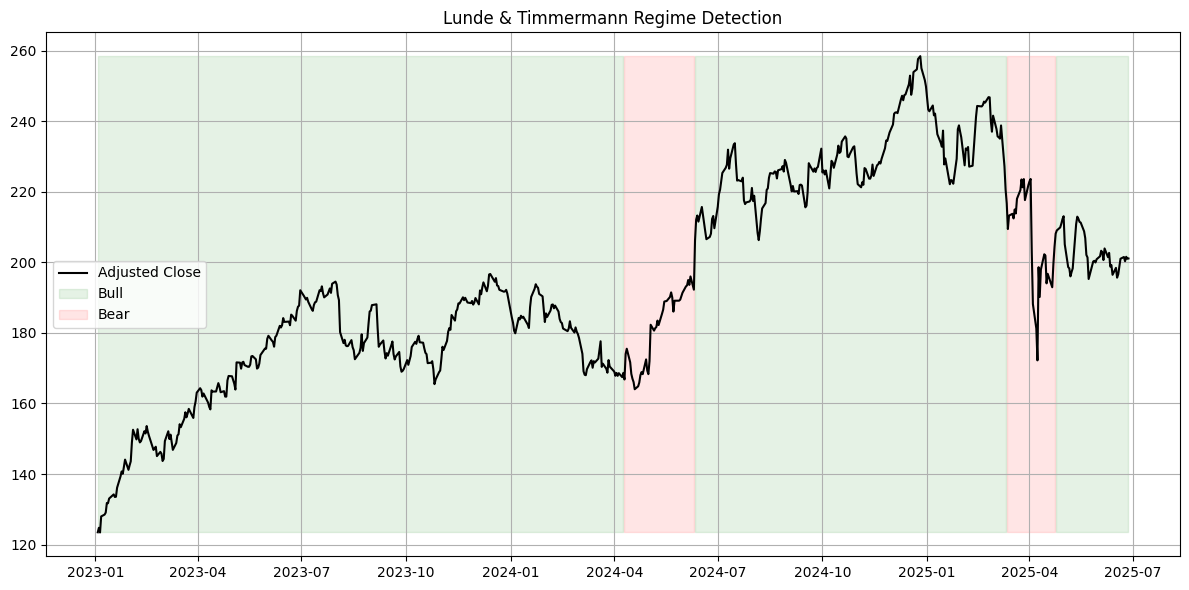

In [344]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(lt_df.index, lt_df['adjClose'], label='Adjusted Close', color='black')

plt.fill_between(lt_df.index, lt_df['adjClose'].min(), lt_df['adjClose'].max(),
                 where=(lt_df['regime'] == 'Bull'), color='green', alpha=0.1, label='Bull')
plt.fill_between(lt_df.index, lt_df['adjClose'].min(), lt_df['adjClose'].max(),
                 where=(lt_df['regime'] == 'Bear'), color='red', alpha=0.1, label='Bear')

plt.title("Lunde & Timmermann Regime Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🫧 K-means Clustering
K-means clustering is an unsupervised learning method that groups similar periods in market data based on features like returns, volatility, and momentum. It allows segmenting historical periods into distinct market regimes, making it easier to assign optimal trading strategies.\

When the market is in a trend, momentum strategies thrive. When high volatility is detected in asset price, volatility breakout strategies perform well. In a quiet, sideways market, mean-reversion strategies work better.

In [345]:
# Import and Setup
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [346]:
# Load historical TSLA data
data = fetch_daily_data("TSLA", "2023-01-01", "2025-06-27").sort_index(ascending = True)

# Calculate log return
data['logReturn'] = np.log(data['adjClose']).diff()

# Rolling 20-day volatility as risk regime proxy
data['volatility'] = data['logReturn'].rolling(window=20).std()

# Calculate momentum
data['momentum'] = data['adjClose'].pct_change(20)

# Standardize each feature
features = data[['logReturn', 'volatility', 'momentum']].dropna()
scaled = StandardScaler().fit_transform(features)

In [347]:
# Find the suitable k by fitting a K-Means model for each k
n_clusters = np.arange(1, 7)
models = [KMeans(n, init='k-means++').fit(features) for n in n_clusters]

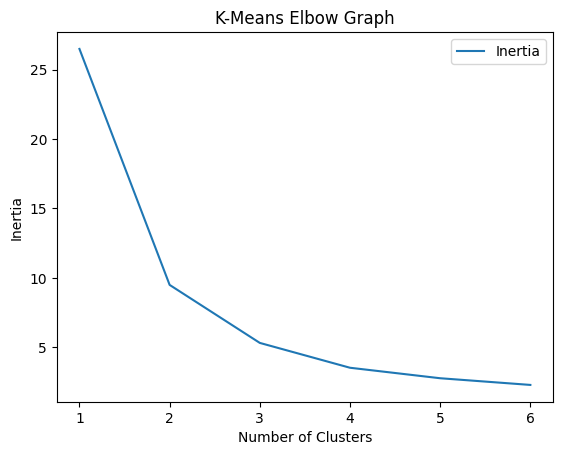

In [348]:
# Plotting of intertia
plt.plot(n_clusters, [m.inertia_ for m in models], label='Inertia')

plt.legend(loc='best')
plt.title('K-Means Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [349]:
# Apply K-Means with k = 3
kmeans = KMeans(n_clusters=3, random_state=42)
data.loc[features.index, 'regime'] = kmeans.fit_predict(scaled)

In [350]:
# Extract mean log return, volatility, and momentum of each cluster
cluster_means = features.copy()
cluster_means['cluster'] = kmeans.labels_
print(cluster_means.groupby('cluster').mean())

         logReturn  volatility  momentum
cluster                                 
0         0.014996    0.037317  0.349424
1         0.008211    0.054090 -0.025601
2        -0.006911    0.031084 -0.045070


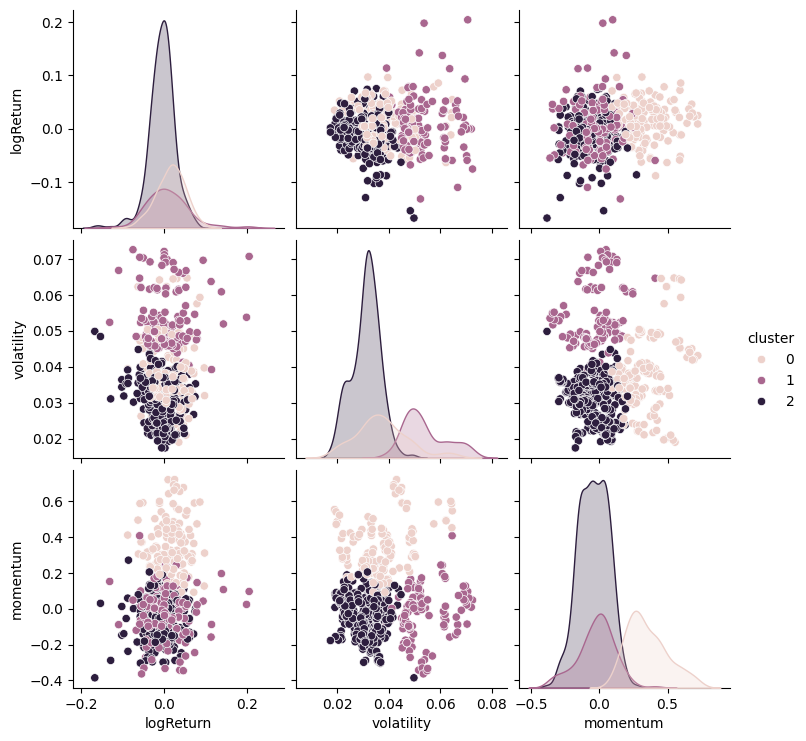

In [351]:
# Plot pairwise scatterplots of all clusters
sns.pairplot(cluster_means, hue='cluster')

In [352]:
# Assign regime per cluster
regime_map = {0: 'Trend', 1: 'Reversion', 2: 'Neutral'}
data['regime'] = data['regime'].map(regime_map)

# Assign strategy per regime
strategy_map = {'Trend': "Momentum", 'Reversion': "Volatility Breakout", 'Neutral': "Mean Reversion"}
data['strategy'] = data['regime'].map(strategy_map)

# Position sizing as a % of normal size: more aggressive in Trend, more conservative in Neutral
data['posSize (%)'] = data['regime'].map({
    "Trend": 1.0,
    "Reversion": 0.7,
    "Neutral": 0.5
}) 

# Sort data in descending order of date
data = data.sort_index(ascending = False)

data.head()

,open,high,low,close,volume,adjClose,logReturn,volatility,momentum,regime,strategy,posSize (%)
2025-06-27,324.51,329.3393,317.495,323.63,89067049,323.63,-0.006621,0.047782,-0.097090,Reversion,Volatility Breakout,0.7
2025-06-26,324.61,331.0500,323.610,325.78,80440907,325.78,-0.005418,0.047826,-0.087195,Reversion,Volatility Breakout,0.7
2025-06-25,342.70,343.0000,320.400,327.55,119845050,327.55,-0.038686,0.047903,-0.097385,Reversion,Volatility Breakout,0.7
2025-06-24,356.17,356.2600,340.440,340.47,114736245,340.47,-0.023828,0.049804,0.003330,Reversion,Volatility Breakout,0.7
2025-06-23,327.54,357.5400,327.480,348.68,190716815,348.68,0.079106,0.049504,0.022402,Reversion,Volatility Breakout,0.7


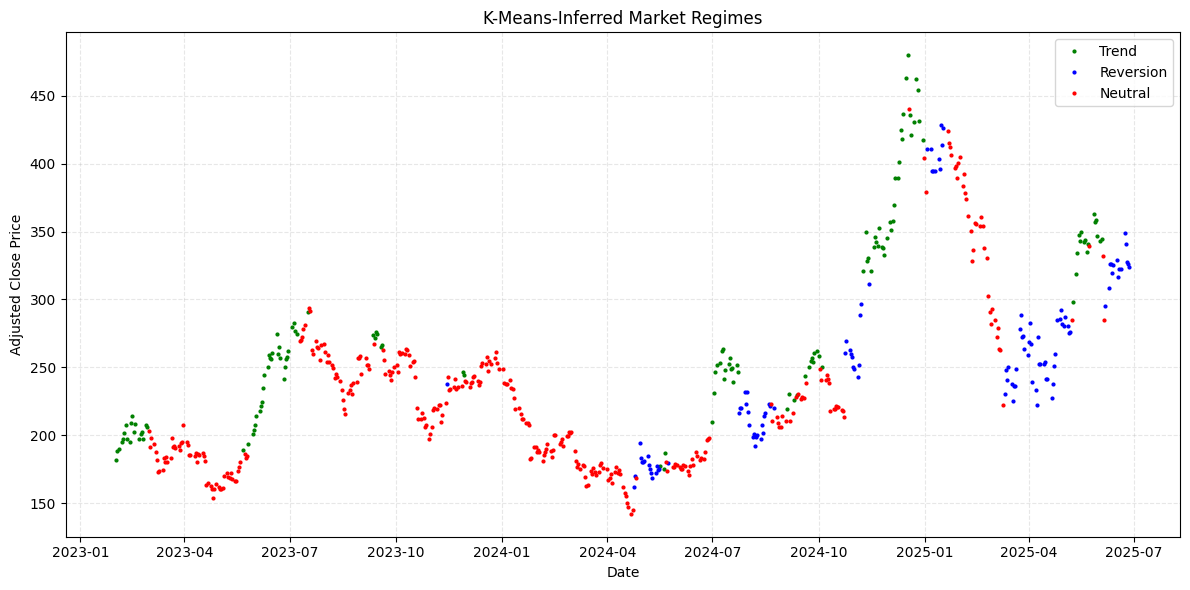

In [353]:
# Map each regime to a color
regime_colors = {0: 'green', 1: 'blue', 2: 'red'}

plt.figure(figsize=(12, 6))

for regime in range(3):
    mask = data['regime'] == regime_map[regime]
    plt.plot(data.index[mask], data['adjClose'][mask], 
             '.', label=regime_map[regime], color=regime_colors[regime], markersize=4)

plt.legend()
plt.title('K-Means-Inferred Market Regimes')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## 🕸 Hidden Markov Model (HMM)
HMM is a probabilistic model that assumes market regimes are hidden states generating observable returns and infers these latent states and their probabilities. It enables dynamic strategy switching and probabilistic risk adjustments.

In [354]:
# Import and Setup
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [355]:
# Load historical TSLA data
data = fetch_daily_data("AMZN", "2023-01-01", "2025-06-27").sort_index(ascending = True)

# Calculate log return
data['logReturn'] = np.log(data['adjClose']).diff()

# Rolling 20-day volatility as risk regime proxy
data['volatility'] = data['logReturn'].rolling(window=20).std()

# Drop NaNs and scale returns
returns = data['logReturn'].dropna().values.reshape(-1, 1)
returns = StandardScaler().fit_transform(returns)

# Apply HMM assuming 3 hidden states
hmm = GaussianHMM(n_components=3, covariance_type='diag', n_iter=2000, random_state=42)
hmm.fit(returns)
hidden_states = hmm.predict(returns)

# Store probabilities of each state
prob_matrix = hmm.predict_proba(returns)
data.loc[data['logReturn'].dropna().index, 'P(state 0)'] = prob_matrix[:, 0]
data.loc[data['logReturn'].dropna().index, 'P(state 1)'] = prob_matrix[:, 1]
data.loc[data['logReturn'].dropna().index, 'P(state 2)'] = prob_matrix[:, 2]

# Store regime and probability
data.loc[data['logReturn'].dropna().index, 'state'] = hidden_states

In [356]:
# Function to calculate autocorrelation
def autocorr_by_state(data, state, lag=1):
    # Select returns for the given state
    returns_state = data.loc[data['state'] == state, 'logReturn']
    
    # Drop NaNs just in case
    returns_state = returns_state.dropna()
    
    # Calculate lagged returns
    returns_lagged = returns_state.shift(lag).dropna()
    returns_state = returns_state.loc[returns_lagged.index]
    
    # Calculate autocorrelation at specified lag
    autocorr = returns_state.corr(returns_lagged)
    return autocorr

# Calculate autocorrelation for each state
for s in range(3):
    ac = autocorr_by_state(data, s, lag=1)
    state_returns = data.loc[data['state'] == s, 'logReturn']
    print(f"State {s} (autocorrelation (lag=1), mean, std) = ({ac:.4f}, {state_returns.mean():.4f}, {state_returns.std():.4f})")

State 0 (autocorrelation (lag=1), mean, std) = (0.0321, 0.0039, 0.0145)
State 1 (autocorrelation (lag=1), mean, std) = (-0.0360, -0.0008, 0.0181)
State 2 (autocorrelation (lag=1), mean, std) = (-0.2713, 0.0020, 0.0564)


In [357]:
# Map strategies to each state
state_map = {
    0: 'Trend',
    1: 'Neutral',
    2: 'Reversion'
}
data['state'] = data['state'].map(state_map)

# Map strategy per state
strategy_map = {'Trend': "Momentum", 'Reversion': "Volatility Breakout", 'Neutral': "Mean Reversion"}
data['strategy'] = data['state'].map(strategy_map)

# Position sizing as a % of normal size: more aggressive in Trend, more conservative in Neutral
data['posSize (%)'] = data['state'].map({
    "Trend": 1.0,
    "Reversion": 0.7,
    "Neutral": 0.5 
}) 

# Sort data in descending order of date
data = data.sort_index(ascending = False)

data.head()

,open,high,low,close,volume,adjClose,logReturn,volatility,P(state 0),P(state 1),P(state 2),state,strategy,posSize (%)
2025-06-27,219.920,223.300,216.7400,223.30,119217138,223.30,0.028066,0.014060,0.483080,0.438691,0.078229,Trend,Momentum,1.0
2025-06-26,213.120,218.035,212.0100,217.12,50480814,217.12,0.023911,0.012886,0.390889,0.562368,0.046743,Neutral,Mean Reversion,0.5
2025-06-25,214.615,216.030,211.1100,211.99,31755698,211.99,-0.003673,0.012043,0.525392,0.450401,0.024208,Trend,Momentum,1.0
2025-06-24,212.135,214.340,211.0450,212.77,38378757,212.77,0.020417,0.013042,0.386049,0.594911,0.019040,Neutral,Mean Reversion,0.5
2025-06-23,209.790,210.390,207.3101,208.47,37311725,208.47,-0.005835,0.012674,0.573381,0.408317,0.018302,Trend,Momentum,1.0


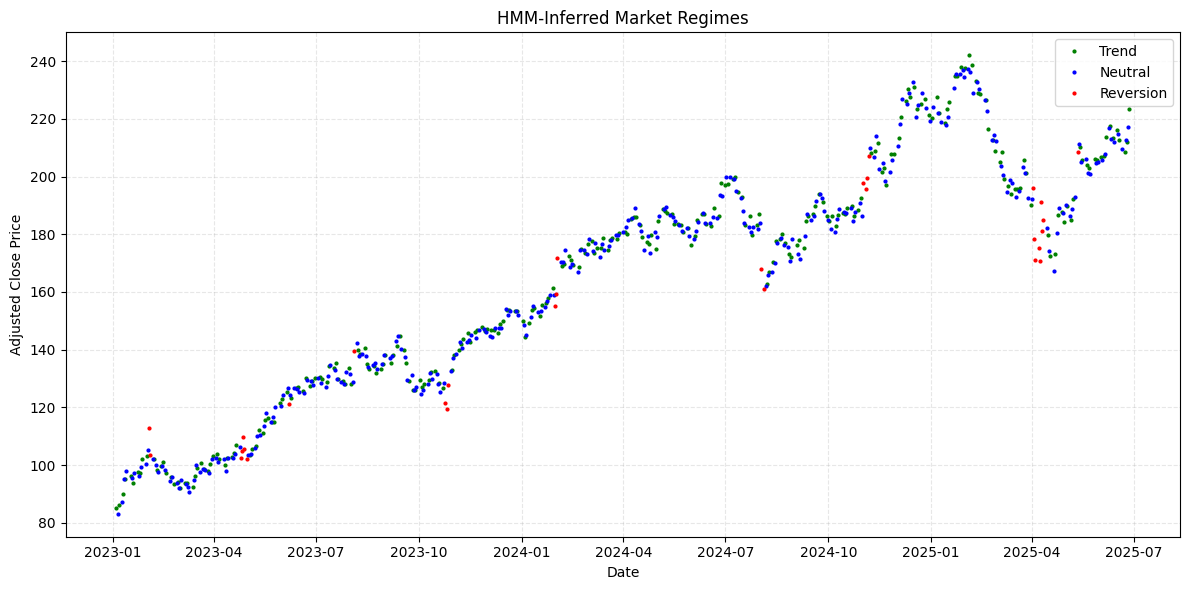

In [360]:
# Map each state to a color
state_colors = {0: 'green', 1: 'blue', 2: 'red'}

plt.figure(figsize=(12, 6))

for state in range(3):
    mask = data['state'] == state_map[state]
    plt.plot(data.index[mask], data['adjClose'][mask], 
             '.', label=state_map[state], color=state_colors[state], markersize=4)

plt.legend()
plt.title('HMM-Inferred Market Regimes')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## 📚 References
1. [How to Identify and Forecast Bull and Bear Markets? -- Erik Kole, Dick van Dijk](https://repub.eur.nl/pub/41558/ERS-2013-016-F&A.pdf)
2. [Clustering with KMeans Method -- Selcukcan](https://www.kaggle.com/code/selcukcan/ml-5a-market-regimes-prediction-using-clustering#Clustering-with-KMeans-Method)
3. []()